In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib widget

In [3]:
import h5py
import librosa

import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

from pathlib import Path
import scipy.signal
import pyroomacoustics as pra
from skimage.restoration import unwrap_phase

import src.utils.dsp_utils as dsp
import src.utils.acu_utils as acu
import src.utils.geo_utils as geo

In [4]:
data_dir = Path('../../../Dataset/SPEAR22/Miscellaneous/Array_Transfer_Functions/Device_ATFs.h5')

# DESCRIPTION: returns dictionary of array's Acoustic Impulse Responses (AIRs) for all measured directions
# *** OUTPUTS ***
# AIR        (dict) dictionary {'IR': (nSample,nDirection,nChannel),'fs': (int),'directions': (N,2),'nChan': (int)}
AIR = {'IR': [],'fs': [],'directions': [],'nChan': [], 'azi': [], 'ele': []}
# IR: (ndarray) Impulse Responses [nSample x nDirection x nChan]
# fs: (int) sample rate in Hz
# directions: (ndarray) (azimuth,elevation) in radians [nDirection x 2] 
# nChan: (int) number of array's sensor/channel
# azi: sorted unique azimuths (radians) [nDirection x 1]
# ele: sorted unique elevations (radians) [nDirection x 1]
f = h5py.File(data_dir,'r')
AIR['fs'] = int(list(f['SamplingFreq_Hz'])[0][0])
AIR['IR'] = np.array(f['IR']) # (ndarray) [nSample x nDirection x nChan]
AIR['ele'] = (np.pi/2)-np.array(f['Theta']) # (ndarray) elevation in radians [1 x nDirection]
AIR['azi'] = np.array(f['Phi']) # (ndarray) azimuth in radians [1 x nDirection]
AIR['directions'] = np.concatenate((AIR['azi'],AIR['ele']),axis=0).T # (ndarray) [nDirection x 2]
AIR['ele'] = np.sort(np.unique(AIR['ele'])) # (ndarray) [nElevation x 1]
AIR['azi'] = np.sort(np.unique(AIR['azi'])) # (ndarray) [nAzimuth x 1]
AIR['nChan'] = AIR['IR'].shape[-1]
f.close()

In [7]:
print(np.diff(np.rad2deg(AIR['ele'])))

[ 9.  9. 12.  9.  9.  9.  9.  9.  9.  9.  9. 12.  9.  9.  9.  9.]


IR (768, 1020, 6)
ele (17,)
azi (60,)
doa (1020, 2)
[[  0.  84.]
 [  0.  75.]
 [  0.  66.]
 ...
 [354. -48.]
 [354. -57.]
 [354. -66.]]
[[  0.  84.]
 [  0.  75.]
 [  0.  66.]
 ...
 [354. -48.]
 [354. -57.]
 [354. -66.]]
(60, 17, 2)
[ 36. -66.]
[ 36. -66.]


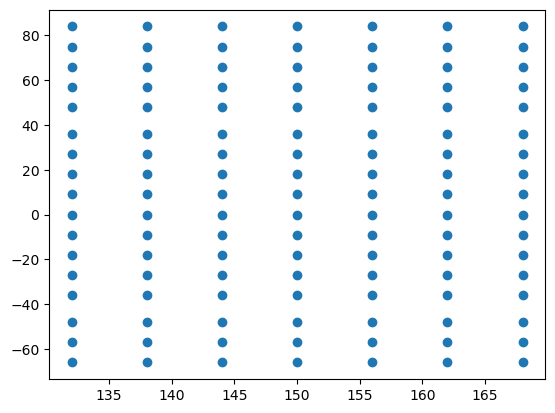

In [7]:
Fs = AIR["fs"]
print('IR', AIR['IR'].shape)
print('ele', AIR['ele'].shape)
print('azi', AIR['azi'].shape)
print('doa', AIR['directions'].shape)
print(np.rad2deg(AIR['directions']))

doa = np.rad2deg(AIR['directions'])
print(doa)

n_az = AIR['azi'].shape[0]
n_el = AIR['ele'].shape[0]

doa_grid = doa.reshape(n_az, n_el, 2)
print(doa_grid.shape)
print(doa_grid[6,16,:])
print(doa[6*n_el+16,:])

az, el = np.split(doa, 2, -1)

az_range = [130, 170]

az_idx = (az > az_range[0]) & (az < az_range[1])

plt.scatter(az[az_idx], el[az_idx])
plt.show()

In [8]:
print(np.min(az), np.max(az))
print(np.min(el), np.max(el))

0.0 354.0
-66.00000000000001 84.0


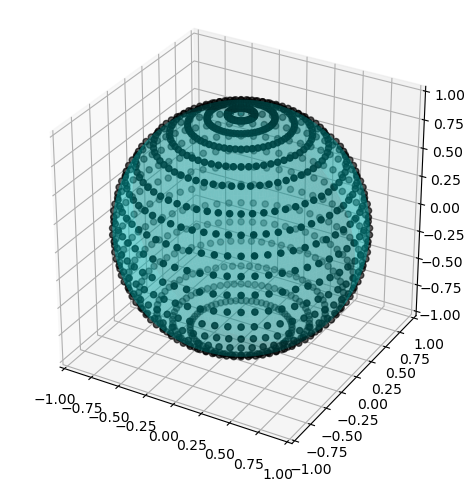

In [9]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

# Create a sphere
r = 1
theta, phi = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
x = r*np.cos(phi)*np.cos(theta)
y = r*np.cos(phi)*np.sin(theta)
z = r*np.sin(phi)

#Import data
doa = AIR['directions']
az, el = np.split(doa, 2, -1)
# el = np.zeros_like(el)
xx = np.cos(el)*np.cos(az)
yy = np.cos(el)*np.sin(az)
zz = np.sin(el)

#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

ax.scatter(xx,yy,zz,color="k",s=20)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_box_aspect((1,1,1))
plt.tight_layout()
plt.show()


(3, 6)


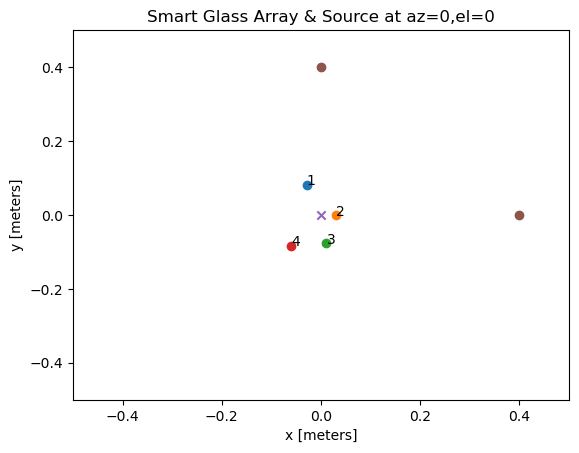

In [10]:
import src.utils.acu_utils as acu

R = acu.get_easycom_array(arr_center=np.zeros([3,1])).mic_pos
print(R.shape)
plt.figure()
x = 0
y = 1
for i in range(4):
    plt.scatter(R[x,i], R[y,i])
    plt.text(   R[x,i], R[y,i], f"{i+1}")

B = np.mean(R, axis=-1)
plt.scatter(0, 0, marker='x')

plt.xlim([-0.50,0.50])
plt.ylim([-0.50,0.50])

az = np.deg2rad(np.array([90, 0]))
el = np.deg2rad(np.array([0, 0]))
r =  0.4
xx = r*np.cos(el)*np.cos(az)
yy = r*np.cos(el)*np.sin(az)

plt.scatter(xx, yy)
plt.title('Smart Glass Array & Source at az=0,el=0')
plt.xlabel("x [meters]")
plt.ylabel("y [meters]")
plt.show()

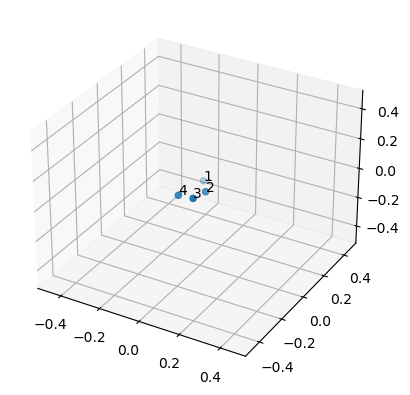

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(R[0,:4], R[1,:4], R[2,:4])
for i in range(4):
    ax.text(R[0,i], R[1,i], R[2,i], f"{i+1}")
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([-0.5, 0.5])
plt.show()

(768, 1020, 6)


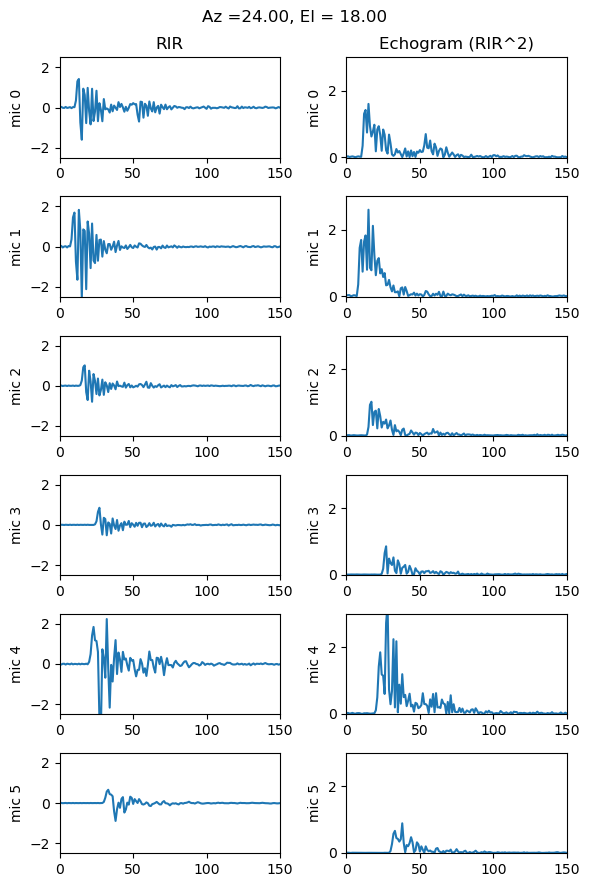

In [12]:
rirs = AIR['IR']
print(rirs.shape)
n = 15*5
az, el = AIR['directions'][n,:]
az = np.rad2deg(az)
el = np.rad2deg(el)

fig, axarr = plt.subplots(6,2,figsize=(6,9))
plt.suptitle(f"Az ={az:1.2f}, El = {el:1.2f}")
for i in range(6):
    axarr[i,0].plot(rirs[:,n,i], label=f'mic {i}')
    axarr[i,0].set_xlim([0,150])
    axarr[i,0].set_ylim([-2.5,2.5])
    axarr[i,0].set_ylabel(f"mic {i}")
    
    axarr[i,1].plot(np.abs(rirs[:,n,i]), label=f'mic {i}')
    axarr[i,1].set_xlim([0,150])
    axarr[i,1].set_ylim([-0.01, 3])
    axarr[i,1].set_ylabel(f"mic {i}")
    
axarr[0,0].set_title("RIR")
axarr[0,1].set_title("Echogram (RIR^2)")
    
plt.tight_layout()
plt.show()

(768, 1020, 6)
torch.complex64
torch.Size([1025, 6])
1025
torch.Size([2048, 6])
torch.Size([768, 6])
False
tensor([[3.4925e-09, 6.7521e-09, 1.0245e-08, 1.1176e-08, 1.6764e-08, 1.1642e-08],
        [0.0000e+00, 7.4506e-09, 6.5193e-09, 0.0000e+00, 3.7253e-09, 1.3970e-09],
        [3.2596e-09, 1.8626e-09, 2.7940e-09, 6.0536e-09, 1.8626e-09, 9.3132e-10],
        ...,
        [1.1642e-09, 6.9849e-10, 5.1223e-09, 1.8626e-08, 1.3271e-08, 6.8685e-09],
        [1.8626e-09, 2.5611e-09, 5.1223e-09, 1.0943e-08, 6.9849e-09, 4.6566e-09],
        [9.3132e-10, 6.2864e-09, 2.3283e-10, 5.5879e-09, 9.3132e-10, 1.1176e-08]])


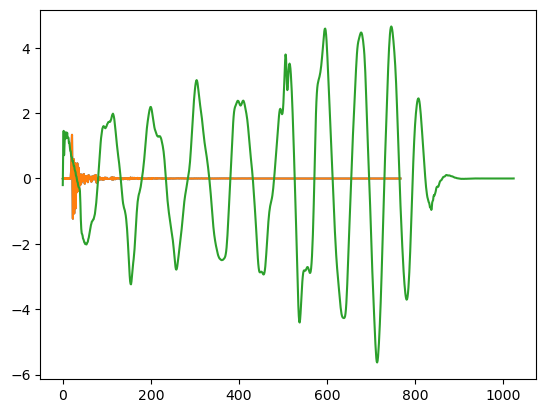

In [13]:
print(rirs.shape)
_air = rirs[:,34,:] # n_smpl x n_chan
import torch

_air = torch.from_numpy(_air).float()
nsmpl = _air.shape[0]
nrfft = 1025
_atf = torch.fft.rfft(_air, 2*(nrfft-1), dim=0)
print(_atf.dtype)
print(_atf.shape)
print(nrfft)
__air = torch.fft.irfft(_atf, n=2*(nrfft-1), dim=0)
print(__air.shape)
__air = __air[:nsmpl,:].real
print(__air.shape)

plt.plot(_air[:,0].numpy())
plt.plot(__air[:,0].numpy())

print(torch.allclose(__air, _air))
print(torch.abs(__air - _air))

plt.plot(_atf.real[:,0].numpy())

(768, 1020, 6)


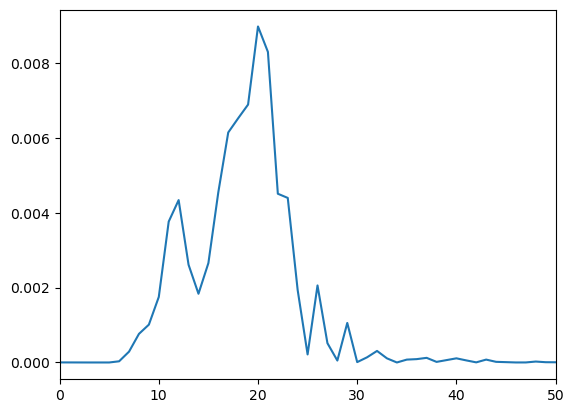

In [14]:
rirs = AIR['IR']

print(rirs.shape)

plt.figure()
plt.plot(rirs[:,:,:4].mean(-1).mean(-1)**2)
plt.xlim([0,50])
plt.show()

(768, 1020, 6)
(257, 60, 6)
(257, 60, 6)
(65, 60, 6)
(128, 60, 6)


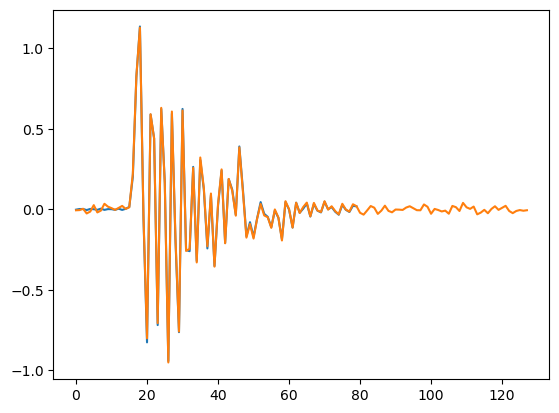

In [15]:
rirs = AIR['IR']
print(rirs.shape)
rirs = rirs.reshape(rirs.shape[0], n_az,n_el, rirs.shape[-1])
n_fft = 512

rirs = rirs[:n_fft//2+1,:,9,:]
print(rirs.shape)

n_smpl = rirs.shape[0]

atfs = np.fft.rfft(rirs, n=n_fft, axis=0)
atfs_x2 = atfs[::4,...]
rirs_x2 = np.fft.irfft(atfs_x2, n=n_fft//4, axis=0)[:n_smpl,...]
print(atfs.shape)
print(atfs_x2.shape)
print(rirs_x2.shape)
n_rfft = atfs.shape[0]

plt.plot(rirs[:80,0,0])
plt.plot(rirs_x2[:,0,0])

In [16]:
import scienceplots

In [24]:
with plt.style.context(['science', 'ieee']):

    for i in [0,4]:
        
        fig, ax = plt.subplots()
        to_plot = rirs_x2[:80,::2,i]
        ax.imshow(to_plot, extent=[0,360,to_plot.shape[0],0], aspect=360/to_plot.shape[0], interpolation=None)
        # ax.imshow(to_plot, extent=[0,360,to_plot.shape[0],0], aspect=0.4*360/to_plot.shape[0])
        # plt.xlabel("Azimuth [degree]")
        # plt.ylabel("Time [samples]")
        # plt.title("Low Res. Time-domain Steering Vector")
        plt.savefig(f"./figures/svect_lr_time_mic-{i}.png")
        plt.tight_layout()
        plt.close()

In [25]:
with plt.style.context(['science', 'ieee']):
    for i in [0,4]:
        to_plot = rirs[:80,:,i]
        fig, ax = plt.subplots()
        plt.imshow(to_plot, extent=[0,360,to_plot.shape[0],0], aspect=360/to_plot.shape[0], interpolation=None)
        # plt.imshow(to_plot, extent=[0,360,to_plot.shape[0],0], aspect=0.4*360/to_plot.shape[0], interpolation=None)
        # plt.xlabel("Azimuth [degree]")
        # plt.ylabel("Time [samples]")
        # plt.title("High Res. Time-domain Steering Vector")
        plt.tight_layout()
        plt.savefig(f"./figures/svect_hr_time_mic-{i}.png")
        plt.close()

In [26]:
with plt.style.context(['science', 'ieee']):
    for i in [0,4]:
        fig, ax = plt.subplots(figsize=(3,3))
        to_plot = 20*np.log10(np.abs(atfs_x2[:,:,i]))
        print(to_plot.shape)
        ax.imshow(to_plot, extent=[0,360,(Fs/2),0], aspect=360/(Fs/2), vmin=-30, interpolation=None)
        # ax.set_xlabel("Azimuth [degree]")
        # ax.set_ylabel("Freqs [Hz]")
        ax.set(yticks=np.arange(5000, Fs/2, 5000), yticklabels=[f"{int(f/1000)}k" for f in np.arange(5000, Fs/2, 5000)])
        # plt.title("Low Res. Freq-domain Steering Vector")
        plt.tight_layout()
        plt.savefig(f"./figures/svect_lr_freq_mic-{i}.png")
        plt.close()

(65, 60)
(65, 60)


In [27]:
with plt.style.context(['science', 'ieee']):
    for i in [0,4]:
        fig, ax = plt.subplots(figsize=(3,3))
        to_plot = 20*np.log10(np.abs(atfs[:,:,i]))
        print(to_plot.shape)
        ax.imshow(to_plot, extent=[0,360,(Fs/2),0], aspect=360/(Fs/2), vmin=-30, interpolation=None)
        # ax.set_xlabel("Azimuth [degree]")
        # ax.set_ylabel("Freqs [Hz]")
        ax.set(yticks=np.arange(5000, Fs/2, 5000), yticklabels=[f"{int(f/1000)}k" for f in np.arange(5000, Fs/2, 5000)])
        # plt.title("High Res. Freq-domain Steering Vector")
        plt.tight_layout()
        plt.savefig(f"./figures/svect_hr_freq_mic-{i}.png")
        plt.close()

(257, 60)
(257, 60)
